# TensorFlow 教程 #15
# 风格迁移

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)/[GitHub中文](https://github.com/Hvass-Labs/TensorFlow-Tutorials-Chinese)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译 [thrillerist](https://zhuanlan.zhihu.com/insight-pixel)

## 介绍

在之前的教程#14中，我们看到了如何最大化神经网络内部的特征激活，以便放大输入图像中的模式。这个称为DeepDream。

本文采用了类似的想法，不过有两张输入图：一张内容图像和一张风格图像。然后，我们希望创建一张混合图像，它包含了内容图的轮廓以及风格图的纹理。

本文基于之前的教程。你需要大概地熟悉神经网络（详见教程 #01和 #02），熟悉教程 #14中的DeepDream也很有帮助。

## 流程图

这张流程图显示了风格迁移算法的大体想法，尽管比起图中所展示出来的，我们所使用的VGG-16模型有更多的层次。

输入两张图像到神经网络中：一张内容图像和一张风格图像。我们希望创建一张混合图像，它包含了内容图的轮廓以及风格图的纹理。
我们通过创建几个可以被优化的损失函数来完成这一点。

内容图像的损失函数会试着在网络的某一层或多层上，最小化内容图像以及混合图像激活特征的差距。这使得混合图像和内容图像的的轮廓相似。

风格图像的损失函数稍微复杂一些，因为它试图让风格图像和混合图像的格拉姆矩阵（Gram-matrices）的差异最小化。这在网络的一个或多个层中完成。 Gram-matrices度量了哪个特征在给定层中同时被激活。改变混合图像，使其模仿风格图像的激活模式(activation patterns)，这将导致颜色和纹理的迁移。

我们用TensorFlow来自动导出这些损失函数的梯度。然后用梯度来更新混合图像。重复多次这个过程，直到我们对结果图像满意为止。

风格迁移算法的一些细节没有在这张流程图中显示出来，比如，对于Gram-matrices的计算，计算并保存中间值来提升效率，还有一个用来给混合图像去噪的损失函数，对损失函数做归一化（normalization），这样它们更容易相对彼此缩放。

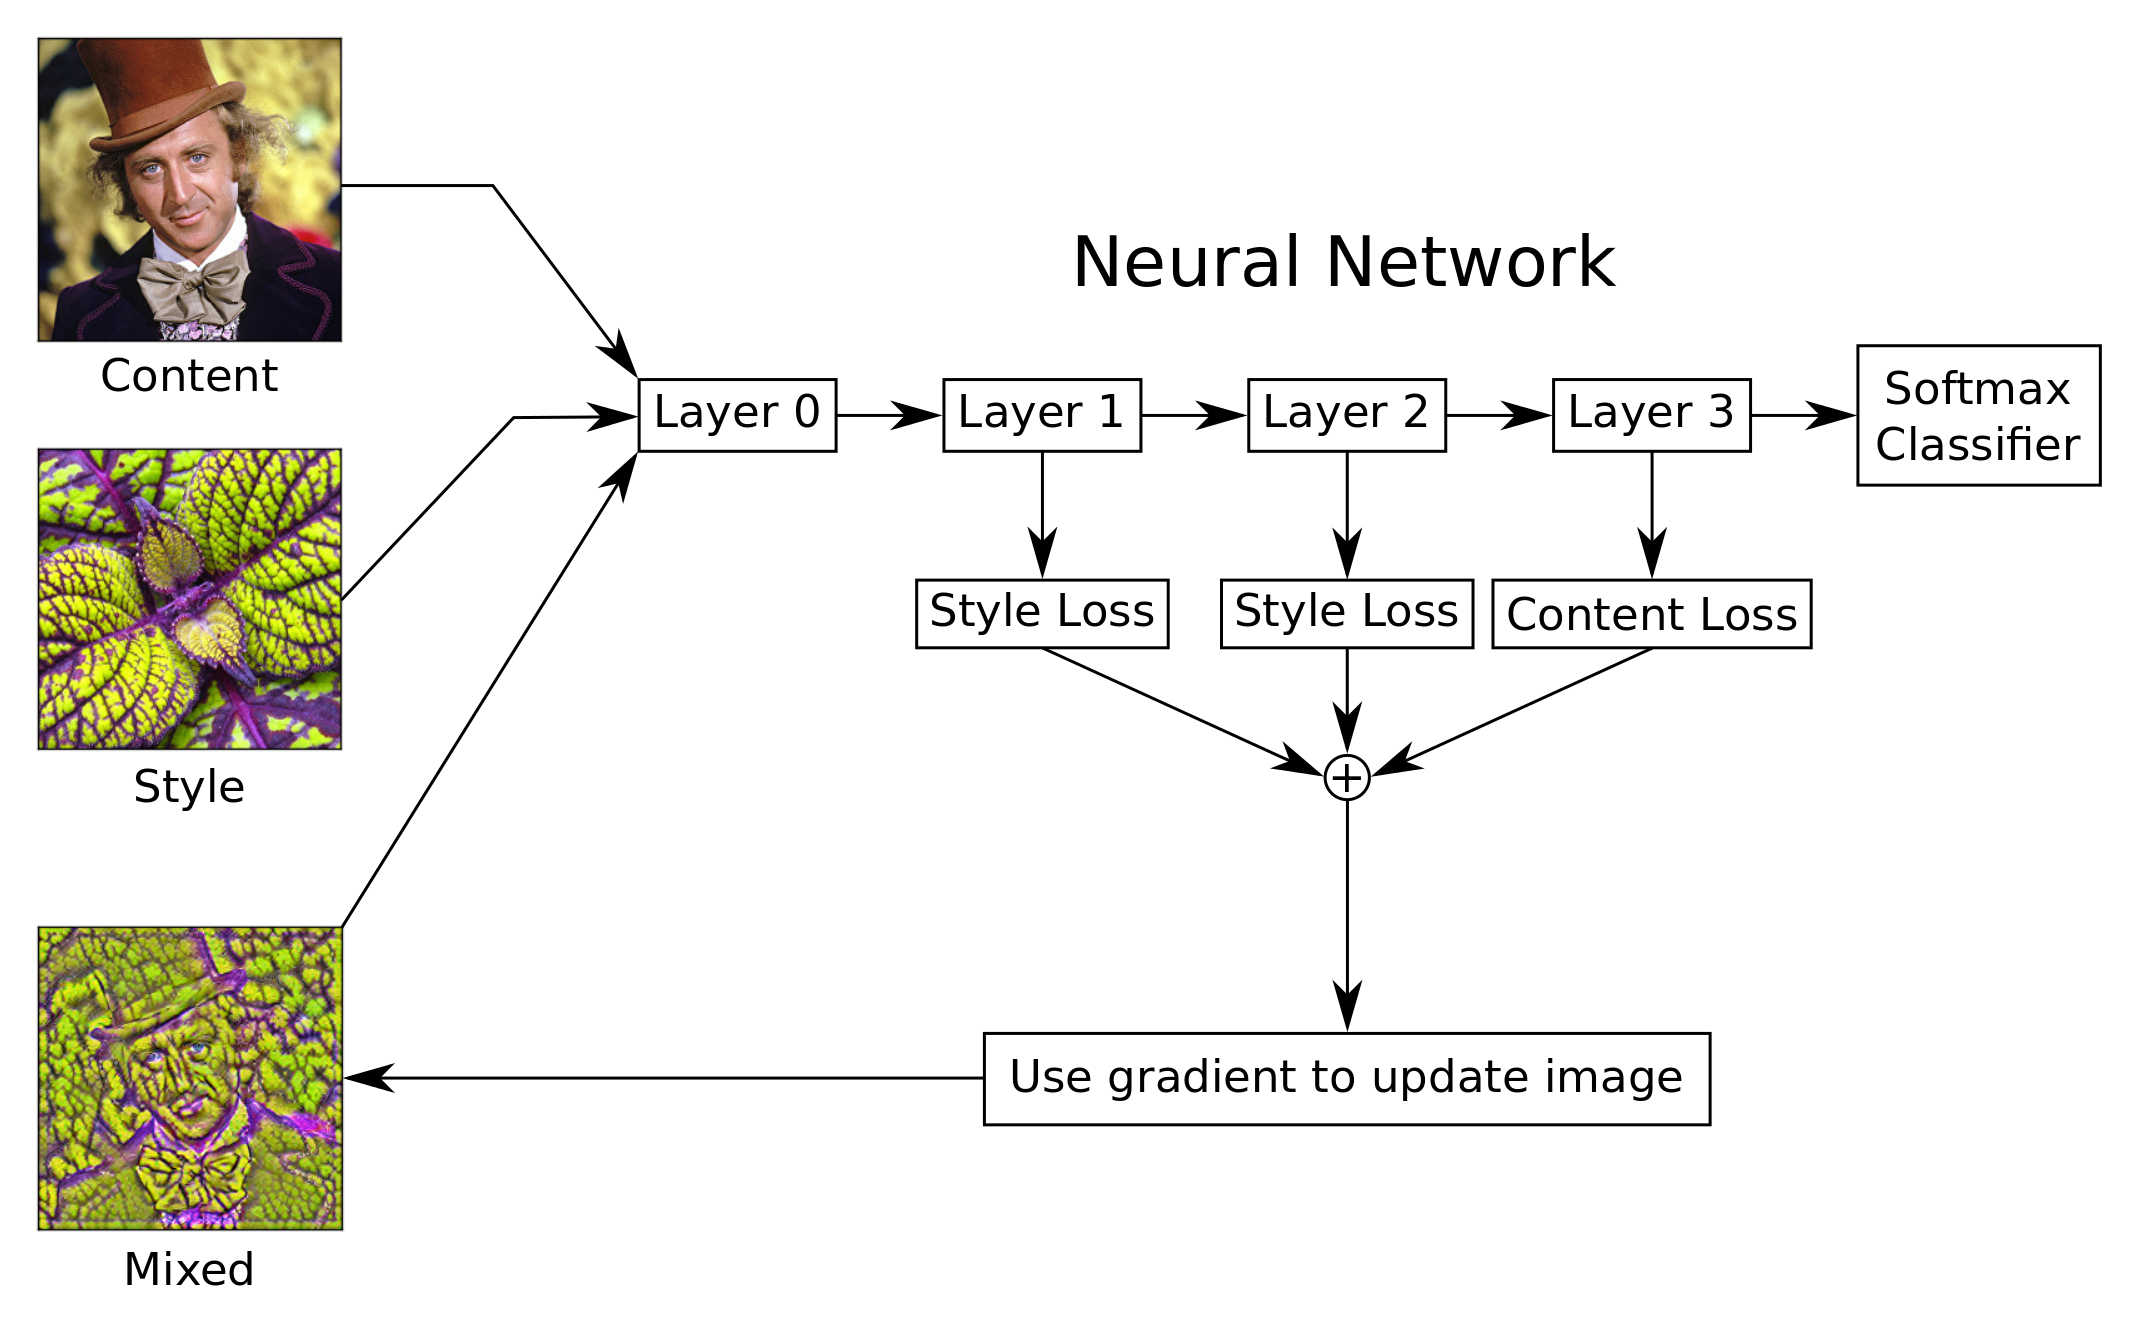

In [1]:
from IPython.display import Image, display
Image('images/15_style_transfer_flowchart.png')

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

使用Python3.5.2（Anaconda）开发，TensorFlow版本是：

In [2]:
tf.__version__

'1.6.0'

## VGG-16 模型

我花了两天时间，想用之前教程#14中在DeepDream上使用的Inception 5h模型来实现风格迁移算法，但无法得到看起来足够好的图像。这有点奇怪，因为教程#14中生成的图像看起来挺好的。但回想起来，我们（在教程#14里）也用了一些技巧来得到这种质量，比如平滑梯度以及递归的降采样并处理图像。

[原始论文](https://arxiv.org/abs/1508.06576) 使用了VGG-19卷积神经网络。出于由于某些原因，对于TendorFlow来说，预训练的VGG-19模型在本教程中不够稳定。因此我们使用VGG-16模型，这是其他人制作的，可以很容易地获取并在TensorFlow中载入。方便起见，我们封装了一个类。

In [3]:
import vgg16

VGG-16模型是从网上下载的。这是你保存数据文件的默认文件夹。如果文件夹不存在，它就会被创建。

In [5]:
# vgg16.data_dir = 'vgg16/'

Download the data for the VGG-16 model if it doesn't already exist in the directory.

**WARNING: It is 550 MB!**

如果文件夹中没有VGG-16模型，就自动下载。 

**注意：它有500MB！**

In [5]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


## 操作图像的帮助函数

这个函数载入一张图像，并返回一个浮点型numpy数组。图像可以被自动地改变大小，因此最大的宽高等于`max_size`。

In [6]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)

将图像保存成一个jpeg文件。给到的图像是一个包含0到255像素值的numpy数组。

In [7]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

这个函数绘制出一张大的图像。给到的图像是一个包含0到255像素值的numpy数组。

In [8]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

 这个函数画出内容图像，混合图像以及风格图像。

In [9]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## 损失函数

这些帮助函数创建了在TensorFlow优化中用的损失函数。

这个函数创建了一个TensorFlow运算，用来计算两个输入张量的最小平均误差（Mean Squared Error）。

In [10]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

这个函数创建了内容图像的损失函数。它是在给定层中，内容图像和混合图像激活特征的最小平均误差。当内容损失最小时，意味着在给定层中，混合图像与内容图像的激活特征很相似。根据你所选择的层次，这会将内容图像的轮廓迁移到混合图像中。

In [11]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

我们将对风格层做相同的处理，但现在需要度量出哪些特征在风格层和风格图像中同时被激活，接着将这些激活模式复制到混合图像中。

 一种办法是为风格层的输出张量计算一个所谓的格拉姆矩阵（Gram-matrix）。Gram-matrix本质上就是风格层中激活特征向量的点乘矩阵。

如果Gram-matrix中的一个元素的值接近于0，这意味着给定层的两个特征在风格图像中没有同时激活。反之亦然，如果Gram-matrix中有很大的值，代表着两个特征同时被激活。接着，我们会试图生成复制了风格图像激活模式的混合图像。

这个帮助函数用来计算神经网络中卷积层输出张量的Gram-matrix。真正的损失函数会在后面创建。

In [12]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram                            

下面的函数创建了风格图像的损失函数。它和上面的`create_content_loss()`很像，除了我们是计算Gram-matrix而非layer输出张量的最小平方误差。

In [13]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

下面创建了用来给混合图像去噪的损失函数。这个算法称为[Total Variation Denoising](https://en.wikipedia.org/wiki/Total_variation_denoising)，本质上就是在x和y轴上将图像偏移一个像素，计算它与原始图像的差异，取绝对值保证差异是正值，然后对整个图像所有像素求和。这个步骤创建了一个可以最小化的损失函数，用来抑制图像中的噪声。

In [14]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

## 风格迁移算法

这是风格迁移主要的优化算法。它基本上就是在上面定义的那些损失函数上做梯度下降。

算法也使用了损失函数的归一化。这似乎是一个之前未发表过的新颖想法。在每次优化迭代中，调整损失值，使它们等于一。这让用户可以独立地设置所选风格层以及内容层的损失权重。同时，在优化过程中也修改权重，来确保保留风格、内容、去噪之间所需的比重。

In [15]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

## 例子

这个例子展示了如何将多张图像的风格迁移到一张肖像上。

首先，我们载入内容图像，它有混合图像想要的大体轮廓。

In [16]:
content_filename = 'images/willy_wonka_old.jpg'
content_image = load_image(content_filename, max_size=None)

然后我们载入风格图像，它拥有混合图像想要的颜色和纹理。

In [17]:
style_filename = 'images/style7.jpg'
style_image = load_image(style_filename, max_size=300)

接着我们定义一个整数列表，它代表神经网络中我们用来匹配内容图像的层次。这些是神经网络层次的索引。对于VGG16模型，第5层（索引4）似乎是唯一有效的内容层。

In [18]:
content_layer_ids = [4]

然后，我们为风格层定义另外一个整型数组。

In [19]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

现在执行风格迁移。它自动地为风格图像、内容图像创建合适的损失函数，然后进行多次优化迭代。这将逐步地生成一张混合图像，其拥有内容图像的大体轮廓，并且它的纹理、颜色和风格图像类似。

在CPU上这个运算会很慢！

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 5.18e-11, Style: 2.14e-29, Denoise: 5.62e-06


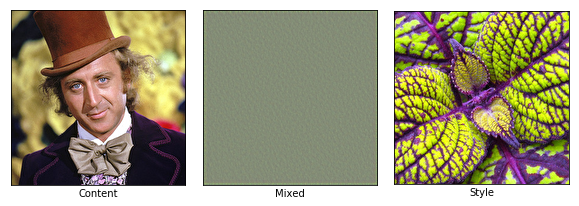

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 2.75e-11, Style: 4.48e-28, Denoise: 1.26e-07


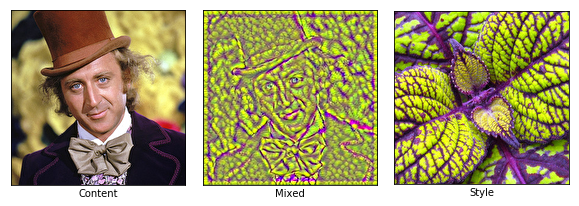

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 2.63e-11, Style: 1.05e-27, Denoise: 1.30e-07


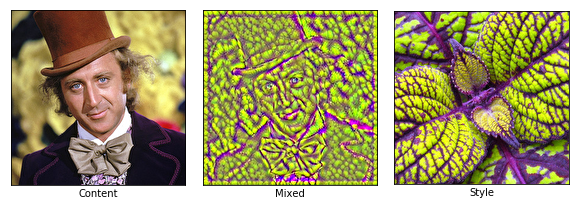

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 2.64e-11, Style: 1.27e-27, Denoise: 1.27e-07


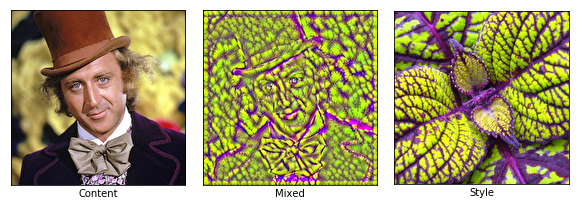

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 2.72e-11, Style: 1.16e-27, Denoise: 1.26e-07


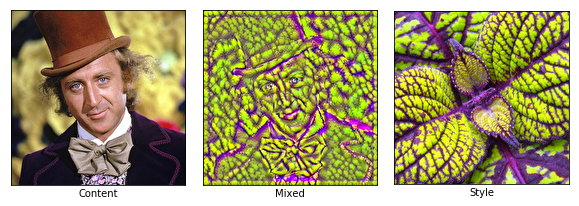

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 2.72e-11, Style: 1.15e-27, Denoise: 1.24e-07


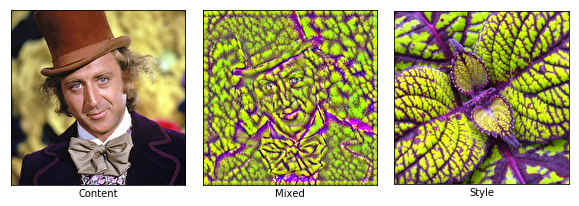

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 1.84e-11, Style: 3.90e-28, Denoise: 1.01e-07


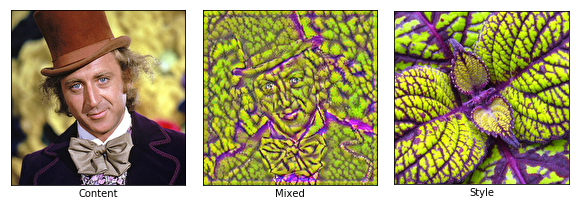


Final image:


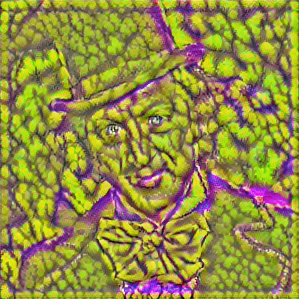

Wall time: 22.4 s


In [20]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)

In [31]:
content_filename = 'images/aaa.jpg'
content_image = load_image(content_filename, max_size=300)
style_filename = 'images/style7.jpg'
style_image = load_image(style_filename, max_size=300)

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 1.39e-10, Style: 2.13e-29, Denoise: 5.61e-06


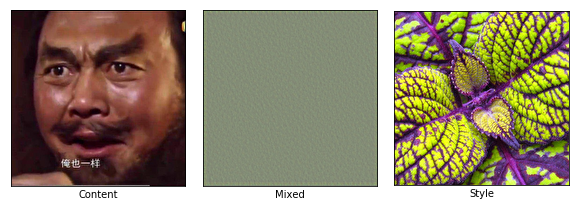

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 2.21e-11, Style: 4.13e-28, Denoise: 1.14e-07


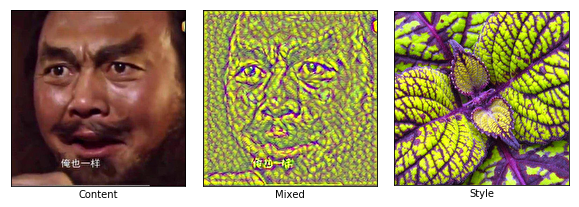

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 1.71e-11, Style: 5.00e-28, Denoise: 1.10e-07


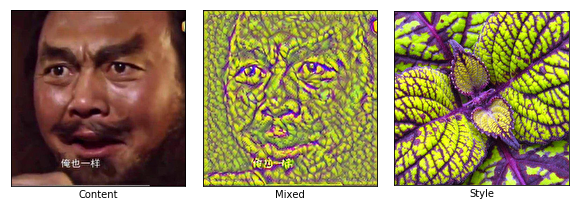

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.77e-11, Style: 8.41e-28, Denoise: 1.09e-07


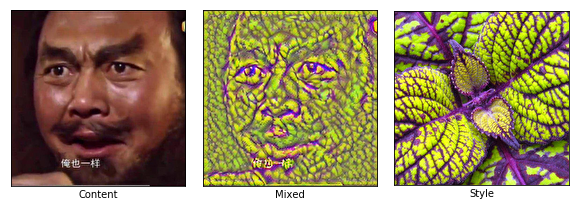

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 1.82e-11, Style: 1.21e-27, Denoise: 1.08e-07


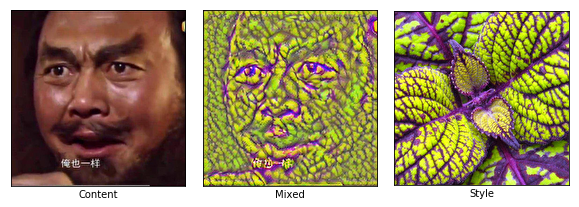

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.85e-11, Style: 1.56e-27, Denoise: 1.07e-07


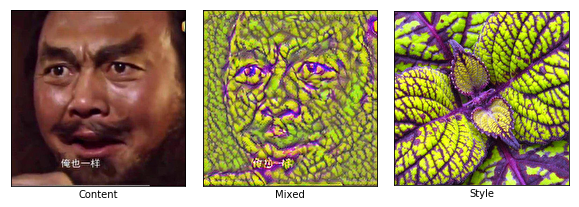

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 2.81e-11, Style: 4.22e-28, Denoise: 1.29e-07


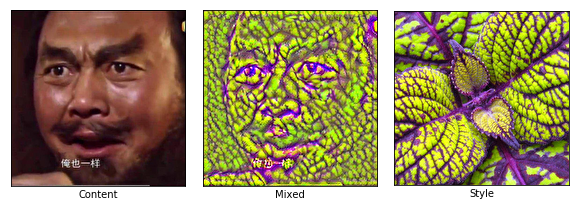


Final image:


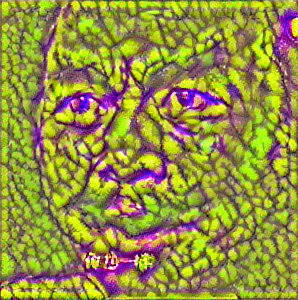

Wall time: 48 s


In [32]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)

In [27]:
save_image(img,'a.jpg')

## 总结

这篇教程说明了用神经网络来结合两张图像内容和风格的基本想法。不幸的是，结果并不像一些商业系统那么好，比如 [DeepArt](http://www.deepart.io)，它是由这种技术的一些先驱者开发的。（结果不好的）原因暂不明确。也许我们只是需要更强的计算力，可以在高分辨率图像上以更小的步长，运行更多的优化迭代。或许我们需要更复杂的优化方法。下面的练习给出了一些可能会提升质量的建议，鼓励你尝试一下。

## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 试着使用其他图像。本文中包含了一些风格图像。你可以使用自己的图像。
* 试着更多的迭代次数（比如1000-5000），以及更小的步长（比如1.0-3.0）。它会提升质量吗？
*　改变风格层、内容层以及去噪时的权重。
* 试着从内容或风格图像开始优化，或许二者的平均。你可以加入一些噪声。
* 试着改变风格图和内容图的分辨率。在`load_image()`函数中，你可以用`max_size`参数来改变图像大小。它对结果有什么影响？
* 试着使用VGG-16模型的其他层。
* 改变代码，使其每10次优化迭代就保存图像。
* 在优化过程中使用常数权重。它对结果有何影响？
* 在风格层中使用不同的权重。同样，试着像其他损失函数一样自动调整权重。
* 用TensorFlow的ADAM优化器来代替基本的梯度下降。
* 使用L-BFGS优化器。目前在TensorFlow中没有实现这个。你能在风格迁移算法中使用SciPy中实现的优化器么？它有提升结果吗？
* 用另外的预训练网络，比如我们在教程 #14中使用的Inception 5h模型，或者用你从网上找到的VGG-19模型。
* 向朋友解释程序如何工作。

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.